# Project #1 Detecting Patterns in Tabular Medical Data with MIMIC-III
You can read more about the dataset here: https://www.kaggle.com/datasets/saurabhshahane/in-hospital-mortality-prediction

Dr. Barak Or

In [5]:
from google.colab import drive
drive.mount('/content/drive')

In [6]:
# my_path="/content/drive/MyDrive/Courses/Deep Learning Google Reichman Tech School/Project 1 MIMIC/"
# my_path=""


In [7]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from sklearn.neighbors import KNeighborsRegressor
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, accuracy_score, classification_report, confusion_matrix
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.utils import resample

# Load the data
data = pd.read_csv("./MIMIC_data.csv")

In [8]:
def balance_dataset(df, column, method='undersample', random_state=42):
    """
    Balance a dataset based on the values in a specified column.

    Parameters:
    df (pandas.DataFrame): Input DataFrame
    column (str): Column name to balance by
    method (str): 'undersample' or 'oversample'
    random_state (int): Random state for reproducibility

    Returns:
    pandas.DataFrame: Balanced DataFrame
    """
    # Get value counts
    value_counts = df[column].value_counts()
    print(f"Original class distribution:\n{value_counts}\n")

    if method == 'undersample':
        # Get the minimum class count
        min_count = value_counts.min()

        # Create balanced dataframe
        balanced_df = pd.concat([
            resample(df[df[column] == val],
                    replace=False,
                    n_samples=min_count,
                    random_state=random_state)
            for val in value_counts.index
        ])

    elif method == 'oversample':
        # Get the maximum class count
        max_count = value_counts.max()

        # Create balanced dataframe
        balanced_df = pd.concat([
            resample(df[df[column] == val],
                    replace=True,
                    n_samples=max_count,
                    random_state=random_state)
            if count < max_count else df[df[column] == val]
            for val, count in value_counts.items()
        ])

    print(f"Balanced class distribution:\n{balanced_df[column].value_counts()}")
    return balanced_df.reset_index(drop=True)



balanced_data_under = balance_dataset(data, 'outcome', method='undersample', random_state=42)
balanced_data_over = balance_dataset(data, 'outcome', method='oversample', random_state=42)

print(data.shape)
print(balanced_data_under.shape)
print(balanced_data_over.shape)


Original class distribution:
outcome
0.0    1017
1.0     159
Name: count, dtype: int64

Balanced class distribution:
outcome
0.0    159
1.0    159
Name: count, dtype: int64
Original class distribution:
outcome
0.0    1017
1.0     159
Name: count, dtype: int64

Balanced class distribution:
outcome
0.0    1017
1.0    1017
Name: count, dtype: int64
(1177, 51)
(318, 51)
(2034, 51)


# Q1.a
What are the mean, median, mode, and standard deviation of the age, BMI, and Blood sodium columns in the dataset? Why are these statistics important for understanding the data?

In [9]:
def calc_stats(dat):
  return dat.mean(),dat.mode()[0], dat.median(), dat.std()

#make it to a df
d = {}
d['age'] = calc_stats(data['age'])
d['BMI'] = calc_stats(data['BMI'])
d['Blood sodium'] = calc_stats(data['Blood sodium'])

d_ = pd.DataFrame(d)
d_['stat']= ['mean','mode','median','std']

d_ = d_.set_index('stat')
print(d_)


              age        BMI  Blood sodium
stat                                      
mean    74.055225  30.188278    138.890016
mode    89.000000  23.296976    140.000000
median  77.000000  28.312474    139.250000
std     13.434061   9.325997      4.151347


# Answer Q1. a
```
              age        BMI  Blood sodium
stat                                      
mean    74.055225  30.188278    138.890016
mode    89.000000  23.296976    140.000000
median  77.000000  28.312474    139.250000
std     13.434061   9.325997      4.151347
```

These stats are important because they give us the general first impression of the data.
They allow us to understand what are the common values and ranges and develope intuition about the data and if there is something unusal about it.

# Q1.b
How do the distributions of age, BMI, and Blood sodium look in the dataset? What can we learn from these distributions about the patient population?

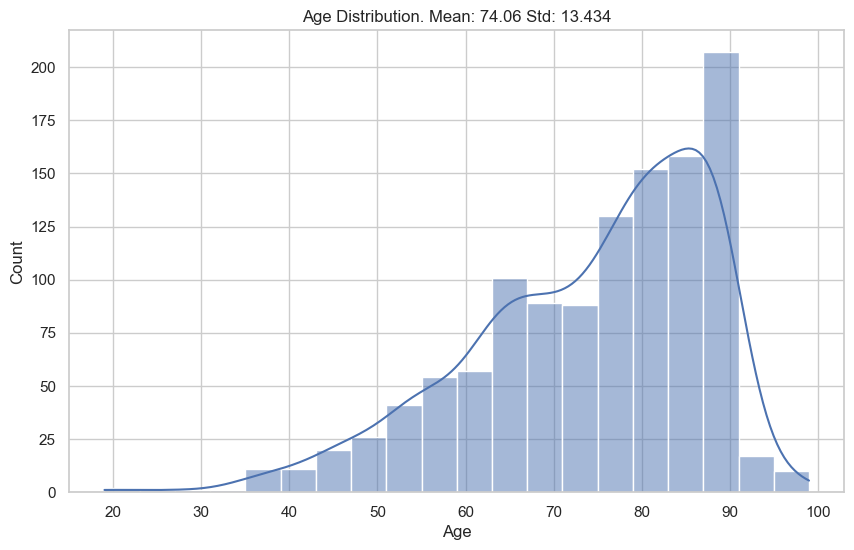

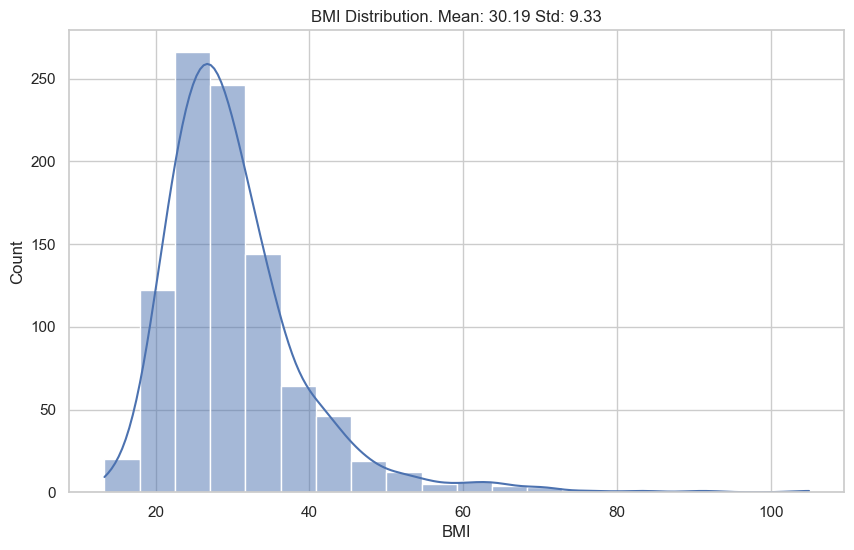

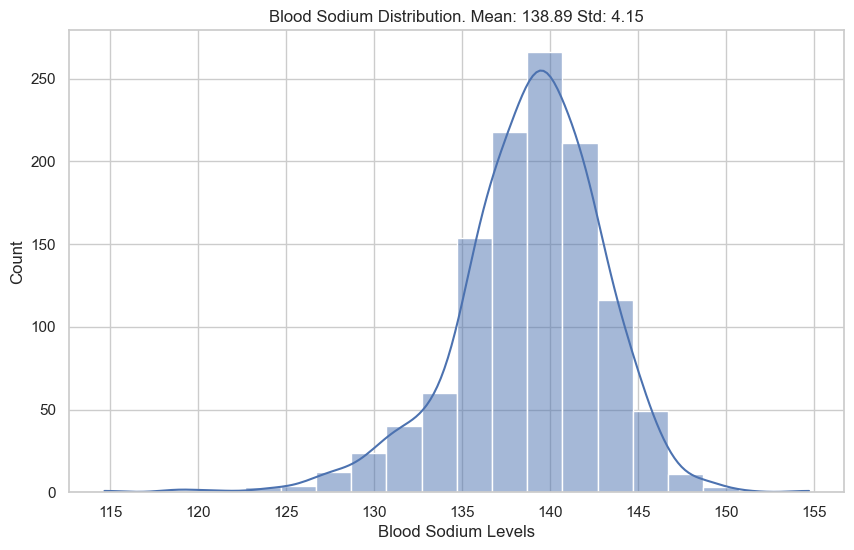

In [10]:
import seaborn as sns
import matplotlib.pyplot as plt

# Set the style for the plots
sns.set(style='whitegrid')

# Histogram for Age Distribution
plt.figure(figsize=(10, 6))  # Optional: set figure size
sns.histplot(data['age'], bins=20, kde=True)  # kde=True adds a Kernel Density Estimate
plt.title(f"Age Distribution. Mean: {d_['age']['mean']:.2f} Std: {d_['age']['std']:.3f}")
plt.xlabel('Age')
plt.ylabel('Count')
plt.show()
# We have more samples from older patients

# Histogram for BMI Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['BMI'], bins=20, kde=True)
plt.title(f"BMI Distribution. Mean: {d_['BMI']['mean']:.2f} Std: {d_['BMI']['std']:.2f}")
plt.xlabel('BMI')
plt.ylabel('Count')
plt.show()
# The mean fits to obese, meaning the average health of the patients is not ideal to begin with

# Histogram for Blood Sodium Distribution
plt.figure(figsize=(10, 6))
sns.histplot(data['Blood sodium'], bins=20, kde=True)
plt.title(f"Blood Sodium Distribution. Mean: {d_['Blood sodium']['mean']:.2f} Std: {d_['Blood sodium']['std']:.2f}")
plt.xlabel('Blood Sodium Levels')
plt.ylabel('Count')
plt.show()
# the mean blood sodium levels appear to be in the normal range


# Q1.b answer
we can conclude from the disterbution above that:
1. Age: We have more samples from older patients (unbalanced dataset), no
   data from kids/teens.
2. BMI: the mean fits to obese, meaning the average health of the patients
   is not ideal to begin with.
3. Blood sodium levels: the mean appears to be in the normal range.




# Q 1.c
Use pandas and scikit-learn to drop rows with missing values in the 'BMI' and 'Blood sodium' columns, and then uses logistic regression, SVM, kNN, and decision tree to predict an 'outcome' based on the features 'age', 'BMI', and 'Blood sodium'. Ensure to split the data using train_test_split with a 20% test size and a random state of 42. Finally, fit the model, make predictions on the test set, and print a report of the best model (“classification_report”). Explain the result of the confusion matrix for the best model.

In [11]:

print(data.shape)
print(data.dropna(subset = 'BMI' or 'Blood sodium').shape)
# data = balanced_data_over
data.dropna().head()
data = data.dropna(subset = 'BMI' or 'Blood sodium') # the data without nans in BMI or Blood sodium


(1177, 51)
(962, 51)


In [12]:
# split to train and test
X = pd.DataFrame(data, columns=['age','BMI','Blood sodium'])
y = pd.Series(data['outcome'], name='outcome') #choose one coloum

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [13]:
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import numpy as np

def train_model(model, X_train, X_test, y_train, y_test):
    """Train a model and evaluate it, returning predictions, accuracy, and other metrics."""
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    return model, y_pred, y_test

def eval_classification_model(model, y_pred, y_test):
    accuracy = accuracy_score(y_test, y_pred)
    report = classification_report(y_test, y_pred, zero_division=1)
    conf_mat = confusion_matrix(y_test, y_pred)
    return accuracy, report, conf_mat

def print_model_results(name, accuracy, report, conf_mat):
    """Print the results of a model evaluation."""

    print(f"Accuracy for {name} : {accuracy:.5f}")
    print("Classification Report:")
    print(report)
    print("Confusion Matrix:")
    print(conf_mat)
    print('-' * 50)


def compare_models(X_train, X_test, y_train, y_test):
    """Compare Logistic Regression, SVM, kNN, and Decision Tree models and print the best."""

    # Initialize models with best parameters for each (based on prior testing)
    models = {
        'Logistic Regression': LogisticRegression(),
        'Support Vector Machine': SVC(kernel='linear'),
        'k-Nearest Neighbors': KNeighborsClassifier(n_neighbors=2),
        'Decision Tree': DecisionTreeClassifier(max_depth=3)
    }

    results = []
    best_model = None
    best_accuracy = 0
    accuracy_dict = {}

    # Train and evaluate each model
    for name, model in models.items():
        model_, y_pred, y_test = train_model(model, X_train, X_test, y_train, y_test)
        accuracy, report, conf_mat = eval_classification_model(model_, y_pred, y_test)

        results.append({'name': name, 'accuracy': accuracy, 'report': report, 'conf_mat': conf_mat})
        accuracy_dict[name] = accuracy

        # Print results for each model
        print_model_results(name, accuracy, report, conf_mat)

        # Update best model if current model has better accuracy
        if accuracy > best_accuracy:
            best_accuracy = accuracy
            best_model = name
            best_conf = conf_mat

    # Check if all models have the same accuracy (within a small tolerance)
    accuracies = np.array(list(accuracy_dict.values()))
    if np.allclose(accuracies, accuracies[0], atol=1e-5):  # handles floating point variations
        print(f"All models have the same accuracy: {accuracies[0]:.5f}")
        # print(f"\nWith confusion matrix: \n {results[-1]['conf_mat']}")
        # # tn, fp, fn, tp = results[-1]['conf_mat'].ravel()
        # # print(tn, fp, fn, tp)




    else:
        print(f"\nThe best model is: {best_model} with an accuracy of {best_accuracy:.5f}")
        # print(f"\nWith confusion matrix: \n {best_conf:.5f}")
        print(best_conf)


    # Return the results for further analysis if needed
    return accuracy_dict

# Example usage:
# Assuming X_train, X_test, y_train, y_test are defined
r = compare_models(X_train, X_test, y_train, y_test)
print(r)


Accuracy for Logistic Regression : 0.85492
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       165
         1.0       1.00      0.00      0.00        28

    accuracy                           0.85       193
   macro avg       0.93      0.50      0.46       193
weighted avg       0.88      0.85      0.79       193

Confusion Matrix:
[[165   0]
 [ 28   0]]
--------------------------------------------------
Accuracy for Support Vector Machine : 0.85492
Classification Report:
              precision    recall  f1-score   support

         0.0       0.85      1.00      0.92       165
         1.0       1.00      0.00      0.00        28

    accuracy                           0.85       193
   macro avg       0.93      0.50      0.46       193
weighted avg       0.88      0.85      0.79       193

Confusion Matrix:
[[165   0]
 [ 28   0]]
--------------------------------------------------
Accuracy for k-Nearest Neig

# Q1.c Answer

All models have the same accuracy: 0.85492

```
{
    'Logistic Regression': 0.8549222797927462, 
    Support Vector Machine': 0.8549222797927462,
    'k-Nearest Neighbors': 0.8549222797927462, 
    'Decision Tree': 0.8549222797927462
}
```


1. The Confusion Matrix
    In this case, the confusion matrix gives the following values:
    - True Positives (TP) = 165
    - False Negatives (FN) = 0
    - False Positives (FP) = 28
    - True Negatives (TN) = 0

2. [Analysing the Truth table to terms we learnd:
So for the metrics we learned in class:
- Accuracy = (TP + TN) / (TP + TN + FP + FN) = (165 + 0) / (165 + 0 + 28 + 0) = 165 / 193 ≈ 0.8549 or 85.49%
- Precision = TP / (TP + FP) = 165 / (165 + 28) = 165 / 193 ≈ 0.8549 or 85.49%
- Recall (Sensitivity) = TP / (TP + FN) = 165 / (165 + 0) = 1 or 100%
- Specificity = TN / (TN + FP)= 0 / (0 + 28) = 0 or 0%
- F1 Score = 2 * (Precision * Recall) / (Precision + Recall) = 2 * (0.8549 * 1) / (0.8549 + 1) ≈ 0.9217 or 92.17%]

3. Explaining the results for the Confusion Matrix
    - This model is predicting all instances as positive. It has perfect recall for the positive class but zero specificity for the negative class.
    The accuracy and precision are the same because FN = TN = 0.
    The model's performance suggests it might be biased or the dataset might be imbalanced.
    - It's correctly identifying all positive cases but failing to identify any negative cases, which could be problematic depending on the context of the classification task.

4. Balancing the data set:
    When understanding this, i can realize that i need to manipulate the dataset.
    attached to the file a function for balancing the dataset.
    for undersampling, the the best model is Logistic Regression with 0.54 accuracy [[10 10] [11 15]]
    for oversampling, the best model is KNN with 0.9205 accuracy [[158 24] [3 155]]

I would choose oversampling rather than undersampling because it have better accuracy, yet i am risking the case of overfit.

# Q1.d
Predict BMI based on age and Blood sodium with linear regression, SVM regressor, Decision tree regressor, and kNN refressor. Calculate RMSE, MSE, R-squared.
Split where 20% left for the test, random state=42.

Linear Regessor 
 MSE: 63.69, RMSE: 7.98, R-squared: -0.02
SVM Regressor 
 MSE: 63.69, RMSE: 7.98, R-squared: -0.02
Decision Tree Regressor 
 MSE: 63.69, RMSE: 7.98, R-squared: -0.02
KNN Regressor 
 MSE: 63.69, RMSE: 7.98, R-squared: -0.02


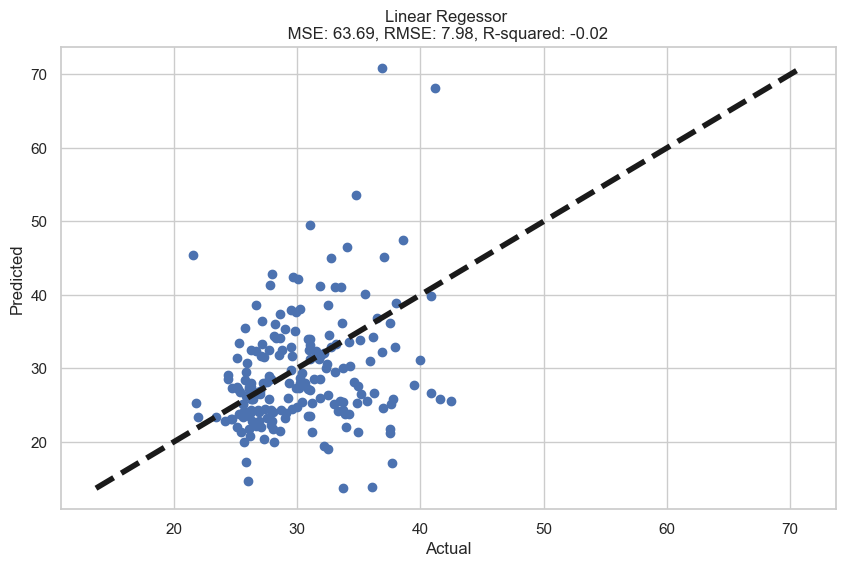

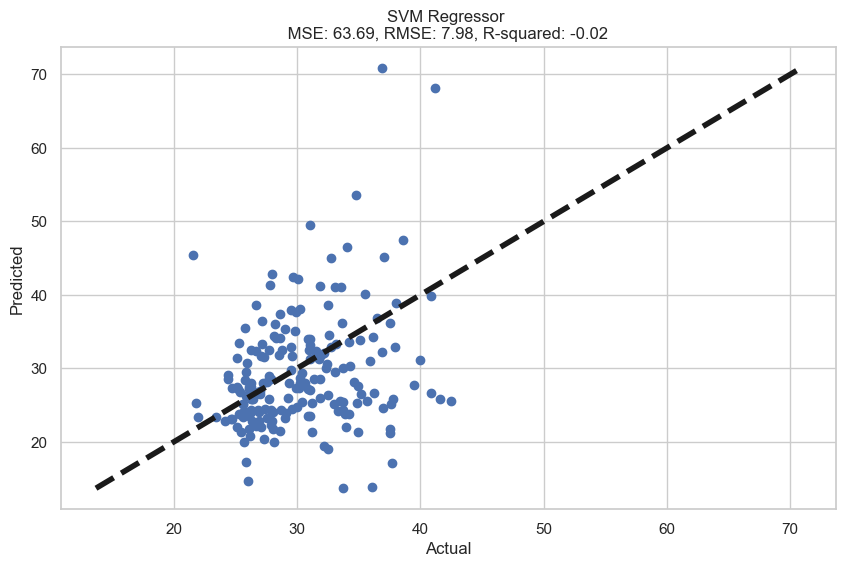

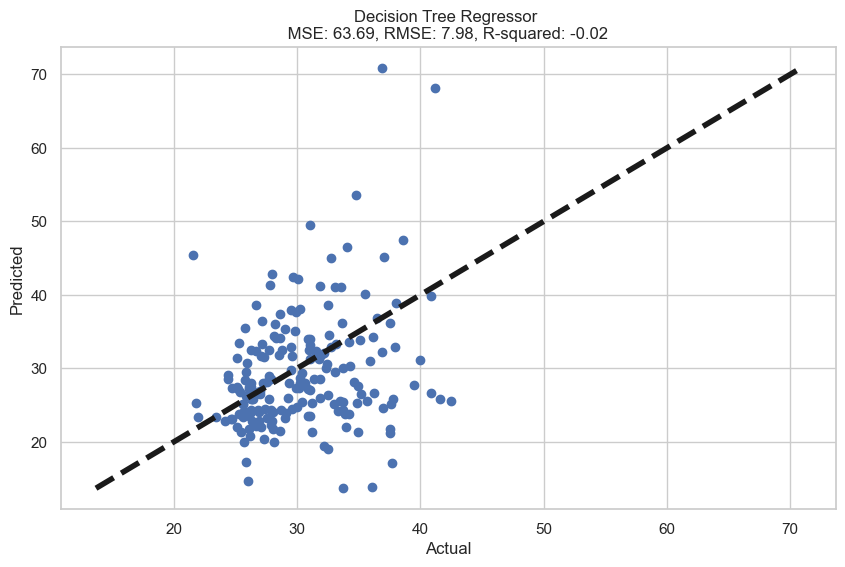

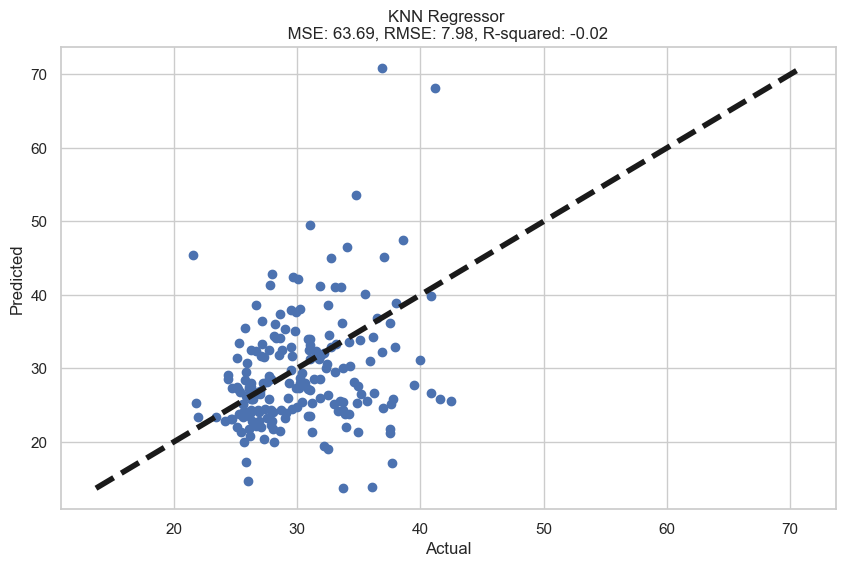

In [14]:
from sklearn.metrics import mean_squared_error, r2_score

models = {'Linear Regessor': LinearRegression(),
          'SVM Regressor': SVR(),
          'Decision Tree Regressor': DecisionTreeRegressor(),
          'KNN Regressor': KNeighborsRegressor()}

X = pd.DataFrame(data, columns=['age','Blood sodium'])
y = pd.Series(data['BMI'], name='BMI') #choose one coloum

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)


def eval_regression_model(name, y_pred, y_test):
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_test, y_pred)
    return (f"{name} \n MSE: {mse:.2f}, RMSE: {rmse:.2f}, R-squared: {r2:.2f}")

    # print(f"{name} \n MSE: {mse:.2f}, RMSE: {rmse:.2f}, R-squared: {r2:.2f} \n ******* \n\n\n")

    # return mse, r2

def plot_pred(x,y,name):
    plt.figure(figsize=(10, 6))
    plt.scatter(x,y)
    plt.plot([y.min(), y.max()], [y.min(), y.max()], 'k--', lw=4) # approx the slope
    plt.title(f"{name} ")
    plt.xlabel('Actual')
    plt.ylabel('Predicted')


def print_plot_models_results(models,X_train, X_test, y_train, y_test):
    for name, model in models.items():
        model, y_pred, y_test = train_model(models['Linear Regessor'],X_train, X_test, y_train, y_test)
        title = eval_regression_model(name, y_pred, y_test)
        print(title)
        plot_pred(y_pred,y_test,title)

print_plot_models_results(models,X_train, X_test, y_train, y_test)



# Q1.d
- Linear Regessor 
     - MSE: 63.69
     - RMSE: 7.98
     - R-squared: -0.02
- SVM Regressor 
     - MSE: 63.69
     - RMSE: 7.98
     - R-squared: -0.02
- Decision Tree Regressor 
     - MSE: 63.69
     - RMSE: 7.98
     - R-squared: -0.02
- KNN Regressor 
     - MSE: 63.69
     - RMSE: 7.98
     - R-squared: -0.02


# Q2.a
Demonstrate the application of Principal Component Analysis (PCA) and t-Distributed
Stochastic Neighbor Embedding (t-SNE) for dimensionality reduction on the dataset

focusing on BMI, Blood sodium, and Blood calcium to visualize the data in a reduced-
dimensional space. Compare the visualization results of PCA and t-SNE.

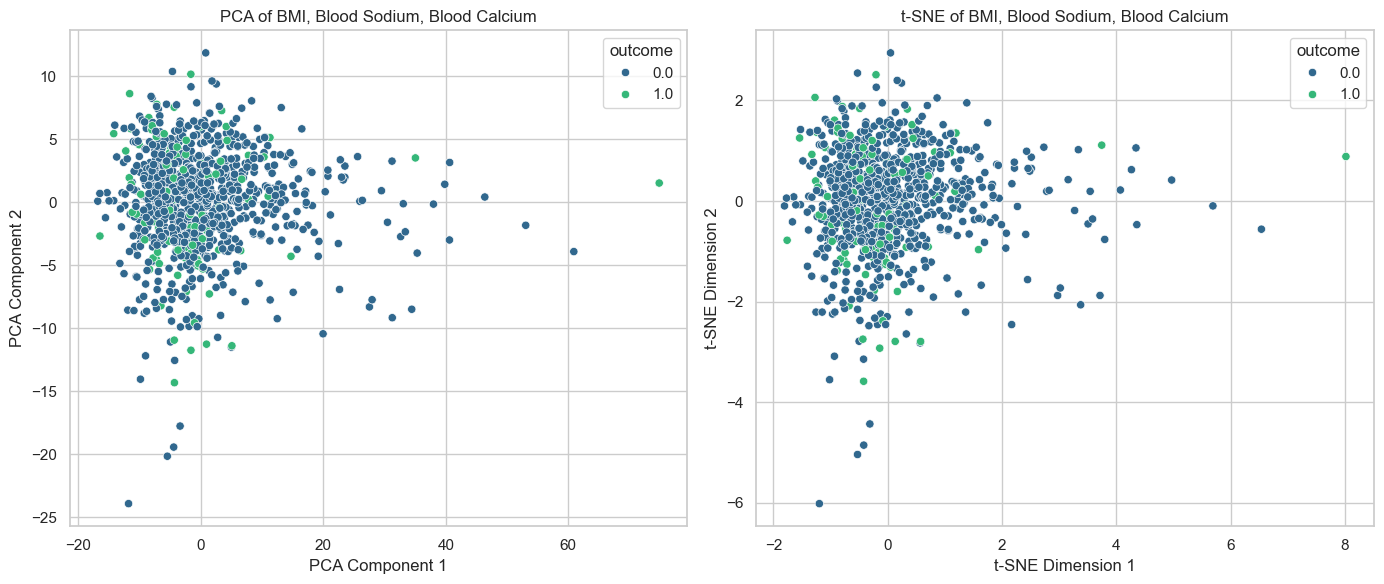

In [18]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import seaborn as sns


# Prepare the data for the task
# remove rows with missing values for the releant features
data_clean = data.dropna(subset=['BMI', 'Blood sodium', 'Blood calcium'])
features = data_clean[['BMI', 'Blood sodium', 'Blood calcium']]
target_feature = data_clean['outcome']

# calculate PCA
pca = PCA(n_components=2)
features_pca = pca.fit_transform(features)

# calculate t-SNE
tSNE = StandardScaler()
features_tSNE = tSNE.fit_transform(features)

# Plot both methods side by side
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 6))

# Plot PCA
sns.scatterplot(
    x=features_pca[:, 0], y=features_pca[:, 1], hue=target_feature, palette='viridis', ax=ax1
)
ax1.set_title('PCA of BMI, Blood Sodium, Blood Calcium')
ax1.set_xlabel('PCA Component 1')
ax1.set_ylabel('PCA Component 2')

# Plot t-SNE
sns.scatterplot(
    x=features_tSNE[:, 0], y=features_tSNE[:, 1], hue=target_feature, palette='viridis', ax=ax2

)


ax2.set_title('t-SNE of BMI, Blood Sodium, Blood Calcium')
ax2.set_xlabel('t-SNE Dimension 1')
ax2.set_ylabel('t-SNE Dimension 2')

plt.tight_layout()
plt.show()





# Q2.a
In the plots above, the outcome color is the original prediction.
It looks like the the analysis didn't give us any distinction between the two groups.
Also, the data seems pretty strongly correlated.


# Q2.b
Apply K-means clustering to the dataset to group patients based on age, BMI, diabetes, and heart rate. Cluster to 2,3,4,5, and 6 groups. What are Silhouette and Davies-Bouldin Score for each case?

In [19]:
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score, davies_bouldin_score
import numpy as np

# relevant data
data_clean = data[['age', 'BMI', 'diabetes', 'heart rate']].dropna()


# Number of clusters to try
cluster_list = list(range(2,7)) # relevant groups
silhouette_scores = []
davies_bouldin_scores = []

# Figure setup for visualization
plt.figure(figsize=(15, 9))

i=0
for cluster in cluster_list:
    # apply K-means clustering
    kmeans = KMeans(n_clusters=cluster, random_state=42)
    clusters = kmeans.fit_predict(data_clean)

    # Silhouette score
    silhouette = silhouette_score(data_clean, clusters)
    silhouette_scores.append(silhouette)

    # Davies-Bouldin score
    davies_bouldin = davies_bouldin_score(data_clean, clusters)
    davies_bouldin_scores.append(davies_bouldin)
    i+=1


# Print Silhouette and Davies-Bouldin Score for each case
davies_silhouette = {}
davies_silhouette['Davies Bouldin Score'] = davies_bouldin_scores
davies_silhouette['Silhouette Score'] = silhouette_scores

davies_silhouette_ = pd.DataFrame(davies_silhouette)
davies_silhouette_['i'] = cluster_list

davies_silhouette_=davies_silhouette_.set_index('i')
print(davies_silhouette_)


   Davies Bouldin Score  Silhouette Score
i                                        
2              1.194230          0.339654
3              1.090292          0.339982
4              1.108055          0.294391
5              1.211871          0.258930
6              1.028109          0.280522


<Figure size 1500x900 with 0 Axes>

# Q2.a
```
   Davies Bouldin Score  Silhouette Score
i                                        
2              1.194230          0.339654
3              1.090292          0.339982
4              1.108055          0.294391
5              1.211871          0.258930
6              1.028109          0.280522
```


A Davies-Bouldin value greater than 1 indicates poor cluster separation, meaning the distances between clusters are smaller than the scatter within the clusters themselves.

# Q3.a
Describe the steps involved in training a neural network, including forward propagation and backpropagation.

## Answer
Steps involved in training a neural network:

1. Initialization: Set initial weights and biases.
2. Forward propagation:
    1. Input data flows through the network
    2. Each neuron computes weighted sum of inputs and applies activation function
    3. Output is produced at the final layer
3. Loss calculation: Compare network output to expected output using a loss function
4. Backpropagation:
    1. Calculate gradients of the loss with respect to weights and biases
    2. Propagate these gradients backwards through the network
5. Parameter update: Adjust weights and biases using an optimization algorithm (eg., gradient descent)
6. Repeat steps 2-5 for multiple epochs until convergence or stopping criterion is met (the error/cost)








# Q3.b
Explain the bias-variance trade-off in neural network performance. How does it affect model generalization?

## Answer
The bias-variance trade-off refers to the balance between a model's ability to fit the training data (low bias) and its ability to generalize to new, unseen data (low variance).
High bias: Model is too simple, underfits the data
High variance: Model is too complex, overfits the data

This trade-off affects generalization in the following ways:

    A model with high bias may fail to capture important patterns in the data
    A model with high variance may fit noise in the training data, leading to poor performance on new data

The goal is to find an optimal balance that minimizes both bias and variance, resulting in a model that generalizes well to new data.


# Q3.c
Highlight the importance of data preprocessing, normalization, and splitting for training effective deep learning models.

## Answer

1. Data preprocessing:
    Removes noise and irrelevant information
    Handles missing values and outliers
    Improves model performance and training efficiency

2. Normalization:
    Scales features to a common range (e.g., 0-1 or -1 to 1)
    Ensures all features contribute equally to the model
    Helps with faster convergence during training
    
3. Data splitting:
    Divides data into training, validation, and test sets
    Training set: Used to train the model
    Validation set: Used for hyperparameter tuning and model selection
    Test set: Used to evaluate final model performance on unseen data
    Helps assess model generalization and prevent overfitting

These processes are crucial for developing effective deep learning models by ensuring the data is clean, properly scaled, and appropriately divided for training and evaluation.



# Q3.d+e

Relevant library from tensorflow

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np


Ensuring data is clean and ready with all features

In [ ]:
# 1

# clean the data and select relevant features
clean_data = data[['age','Blood sodium','outcome']].dropna()
X = clean_data[['age','Blood sodium']]
y = clean_data[['outcome']]

# standardtize the data
X_standrd = StandardScaler()
X_standrd = X_standrd.fit_transform(X)


# 2
X_train, X_test, y_train, y_test = train_test_split(X_standrd, y, test_size=0.2, random_state=42)

# 3 construct DNN
model = Sequential([
    Dense(3, activation='relu',input_shape=(X_train.shape[1],)),
    Dropout(0.05),
    Dense(3, activation='relu'),
    Dropout(0.05),
    Dense(3, activation='relu'),
    Dense(1, activation='sigmoid')
])

# 4 Compile the model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train the model
history = model.fit(X_train, y_train, epochs=100, validation_split=0.2, verbose=1)
eval_ = model.evaluate(X_test, y_test, verbose=1)[1]


In [ ]:
# Plotting functions
def plot_accuracy(history):
    plt.subplot(1,2,1)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')

    # accuracy = model.evaluate(X_test, y_test, verbose=1)[1]

    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    return plt

def plot_loss(history):
    plt.subplot(1,2,2)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    return plt

# Plot accuracy and loss
plt.figure(figsize=(10, 6))
plot_accuracy(history)
plot_loss(history)
plt.show()


In [ ]:
# 5 - Evaluate and Visualize Model Performance
y_pred = (model.predict(X_test) > 0.5).astype("int32")
conf_mat = confusion_matrix(y_test, y_pred)
# Plot the confusion matrix using seaborn
sns.heatmap(conf_mat, annot=True, fmt='d', cmap='Blues')

# Set labels and title
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')

# Show the plot
plt.show()

model.summary()


# My own network!
This part was done using W&B, which helped my keep track of the accuracy values.
From the over-sampled data set, i preformed a fit for each feature alone,
I took the feature's whos accuracy was more than 0.5 (meaning more than by chance), and used them to train a new model.



In [ ]:
import pandas as pd
import numpy as np
from scipy import stats
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import tensorflow as tf
from tensorflow import keras

import os

import wandb
from wandb.integration.keras import WandbCallback

# Load the data
# wandb.login()


# build input pipeline using tf.data


def get_train_and_val(data_feaure_and_prediction, BATCH_SIZE = 64):
    """_summary_
    this function gets the relevant feaure and variables
    Args:
        data_feaure_and_prediction (_type_): the last colum should be the output, the first ones should be the feature(s)
        BATCH_SIZE (int, optional): _description_. Defaults to 64.

    Returns:
        _type_: _description_
    """
    # data_feaure_and_prediction = data_feaure_and_prediction.dropna() # drop the irrelevant values
    X = data_feaure_and_prediction[data_feaure_and_prediction.keys()[:-1]] # the feature
    y = data_feaure_and_prediction[data_feaure_and_prediction.keys()[-1]] # its prediction

    X_standard = StandardScaler()
    X_standard = X_standard.fit_transform(X)
    X_train, X_test, y_train, y_test = train_test_split(X_standard, y, test_size=0.2, random_state=42)

    train_dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))
    train_dataset = train_dataset.shuffle(buffer_size=1024).batch(BATCH_SIZE)

    val_dataset = tf.data.Dataset.from_tensor_slices((X_test, y_test))
    val_dataset = val_dataset.batch(BATCH_SIZE)
    return [train_dataset, val_dataset]

def make_model(feature_num, input_name="input name"):
    inputs = keras.Input((feature_num,), name=input_name)
    x1 = keras.layers.Dense(64, activation="relu")(inputs)
    x1 = keras.layers.Dropout(0.3)(x1)

    x2 = keras.layers.Dense(64, activation="relu")(x1)
    x2 = keras.layers.Dropout(0.3)(x2)

    outputs = keras.layers.Dense(10, name="predictions")(x2)

    return keras.Model(inputs=inputs, outputs=outputs)

def train_step(x, y, model, optimizer, loss_fn, train_acc_metric):
    with tf.GradientTape() as tape:
        logits = model(x, training=True)
        loss_value = loss_fn(y, logits)

    grads = tape.gradient(loss_value, model.trainable_weights)
    optimizer.apply_gradients(zip(grads, model.trainable_weights))

    train_acc_metric.update_state(y, logits) # update the weights of the network

    return loss_value

def test_step(x, y, model, loss_fn, val_acc_metric):
    val_logits = model(x, training=False)
    loss_value = loss_fn(y, val_logits)
    val_acc_metric.update_state(y, val_logits)

    return loss_value

def train(train_dataset, val_dataset,  model, optimizer,
          train_acc_metric, val_acc_metric, loss_fn,
          epochs=10, log_step=200, val_log_step=50):

    for epoch in range(epochs):
        print("\nStart of epoch %d" % (epoch,))

        train_loss = []
        val_loss = []

        # Iterate over the batches of the dataset
        for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
            loss_value = train_step(x_batch_train, y_batch_train,
                                    model, optimizer,
                                    loss_fn, train_acc_metric)
            train_loss.append(float(loss_value))

        # Run a validation loop at the end of each epoch
        for step, (x_batch_val, y_batch_val) in enumerate(val_dataset):
            val_loss_value = test_step(x_batch_val, y_batch_val,
                                       model, loss_fn,
                                       val_acc_metric)
            val_loss.append(float(val_loss_value))

        # Display metrics at the end of each epoch
        train_acc = train_acc_metric.result()
        print("Training acc over epoch: %.4f" % (float(train_acc),))

        val_acc = val_acc_metric.result()
        print("Validation acc: %.4f" % (float(val_acc),))

        # Reset metrics at the end of each epoch
        train_acc_metric.reset_state()
        val_acc_metric.reset_state()

        # ⭐: log metrics using wandb.log
        wandb.log({'epochs': epoch,
                   'loss': np.mean(train_loss),
                   'acc': float(train_acc),
                   'val_loss': np.mean(val_loss),
                   'val_acc':float(val_acc)})

# initialize wandb with your project name and optionally with configutations.
# play around with the config values and see the result on your wandb dashboard.

def run_with_feature(feature):
      config = {
            "epochs": 20,
            "batch_size": 32,
            "log_step": 200,
            "val_log_step": 50,
            "feature_used": str(feature)
      }

      run = wandb.init(project='my-tf-integration', config=config)
      config = wandb.config

      prediction = "outcome"

      model_data = data[feature+[prediction]].dropna()
      [train_dataset, val_dataset] = get_train_and_val(model_data)


      # Initialize model.
      model = make_model(len(feature))

      # Instantiate an optimizer to train the model.
      optimizer = keras.optimizers.Adam()
      # Instantiate a loss function.
      loss_fn = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)

      # Prepare the metrics.
      train_acc_metric = keras.metrics.SparseCategoricalAccuracy()
      val_acc_metric = keras.metrics.SparseCategoricalAccuracy()


      train(train_dataset,
            val_dataset,
            model,
            optimizer,
            train_acc_metric,
            val_acc_metric,
            loss_fn,
            epochs=config.epochs,
            log_step=config.log_step,
            val_log_step=config.val_log_step)

      run.finish()  # In Jupyter/Colab, let us know you're finished!



In [ ]:
# Determine the features to train the ulimate model!
data_keys = data.drop(columns=['outcome']).keys()
len(data_keys)
# data_keys = data_keys[

train_acc_dict = dict.fromkeys(data_keys, 0)
val_acc_dict = dict.fromkeys(data_keys, 0)

for elem in data_keys:
    # try:
    run_with_feature([elem])

In [ ]:
# The features with accuracy score over 0.5 from the last block, used to train the model

feature1 =["Urine output", "Lymphocyte", "Bicarbonate", "Leucocyte", "Urea nitrogen",
    "Anion gap", "Neutrophils", "Blood calcium", "Lactic acid", "PH", "Basophils",
    "Respiratory rate", "Blood sodium", "RDW", "Blood potassium", "NT-proBNP", "PT",
    "Systolic blood pressure", "heart rate", "Renal failure", "Chloride", "Platelets",
    "INR", "atrialfibrillation", "deficiencyanemias", "Diastolic blood pressure",
    "hypertensive", "EF", "BMI", "Magnesium ion", "temperature", "Creatinine", "MCH",
    "PCO2", "SP O2", "hematocrit", "MCV", "diabetes", "Hyperlipemia", "age", "ID",
    "COPD", "CHD with no MI", "Creatine kinase", "glucose", "gendera", "depression"
]

run_with_feature(feature1)


# The results I got for this model
Run history:

acc	▁▄▆▆▆▆▇▇▇▇▇▇█▇██████

epochs	▁▁▂▂▂▃▃▄▄▄▅▅▅▆▆▇▇▇██

loss	█▅▄▃▂▂▂▂▂▂▂▂▁▁▁▁▁▁▁▁

val_acc	▁▄▅▆▆▆▇▇▇▇██████████

val_loss	█▅▃▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁


Run summary:

acc	0.90554

epochs	19

loss	0.24534

val_acc	0.9026

val_loss	0.25483